# **Homework #3_P2**

## **Problem 2: GAN (20%)** 
### **Task Definition**
A generative adversarial network (GAN) is a deep learning method in which two neural networks (Generator and discriminator) compete with each other to become more accurate in their predictions.      
In this problem, you will implement a GAN model and train it on a face dataset. Also, you will conduct some experiments to analyze your GAN model. Please follow problems below:

In [1]:
# connect to drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
path = 'drive/My Drive/senior_1/DLCV/HW/hw3'

Mounted at /content/drive


In [ ]:
!gdown --id '1Cz5eLSP7QRMkO0PqxZLldJ36nK6EWHR8' --output hw3_data.zip # 下載資料集
!unzip hw3_data.zip # 解壓縮
# hw3_data/face/train/images.png
# hw3_data/face/train.csv
# hw3_data/face/test/images.png
# hw3_data/face/test.csv

In [ ]:
# set packages
!pip3 install certifi==2020.6.20
!pip3 install cycler==0.10.0
!pip3 install joblib==0.17.0
!pip3 install kiwisolver==1.2.0
!pip3 install matplotlib==3.3.2
!pip3 install numpy==1.18.1
!pip3 install pandas==1.1.3
!pip3 install Pillow==8.0.0
!pip3 install pyparsing==2.4.7
!pip3 install python-dateutil==2.8.1
!pip3 install pytz==2020.1
!pip3 install scikit-learn==0.21.3
!pip3 install scipy==1.2.1
!pip3 install six==1.15.0
!pip3 install torch==1.4.0
!pip3 install torchvision==0.5.0

In [2]:
# Import 需要的套件
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import time
import pandas as pd
import random
import scipy.misc
import argparse
import imageio
from torch.autograd import Variable
from torch.optim import Adam, AdamW
import csv
import matplotlib.pyplot as plt

# 固定隨機種子
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    print("torchvision.__version__ =", torchvision.__version__)
    print("torch.cuda.is_available() =", torch.cuda.is_available())

same_seeds(0)

torchvision.__version__ = 0.5.0
torch.cuda.is_available() = True


#Read image

In [ ]:
def sortfile(path):
    index = []
    image_dir = sorted(os.listdir(path)) # 把圖檔按照編號排列
    for i, file in enumerate(image_dir):
        index.append([file, int(file.replace('.png', ''))])

    index = sorted(index, key = lambda s: s[1])

    return index

def readfile(path, index, mode):
    x = np.zeros((len(index), 64, 64, 3), dtype=np.uint8)
    for i, file in enumerate(index):
        img = imageio.imread(os.path.join(os.path.join(path, mode), file[0]))
        x[i, :, :] = img
    y = pd.read_csv(os.path.join(path, mode + ".csv"))       

    return x, y

In [ ]:
# 分別將 training set、testing set 用 sortfile, readfile 函式讀進來
workspace_dir = './hw3_data'
print("Reading data")

train_index = sortfile(os.path.join(workspace_dir, "face/train"))
train_x, train_y = readfile(os.path.join(workspace_dir, "face"), train_index, "train")
print("finish training_data")

test_index = sortfile(os.path.join(workspace_dir, "face/test"))
test_x, test_y = readfile(os.path.join(workspace_dir, "face"), test_index, "test")
print("finish testing_data")

Reading data
finish training_data
finish testing_data


# Dataset
在 PyTorch 中，我們可以利用 torch.utils.data 的 Dataset 及 DataLoader 來"包裝" data，使後續的 training 及 testing 更為方便。

Dataset 需要 overload 兩個函數：\_\_len\_\_ 及 \_\_getitem\_\_

\_\_len\_\_ 必須要回傳 dataset 的大小，而 \_\_getitem\_\_ 則定義了當程式利用 [ ] 取值時，dataset 應該要怎麼回傳資料。

實際上我們並不會直接使用到這兩個函數，但是使用 DataLoader 在 enumerate Dataset 時會使用到，沒有實做的話會在程式運行階段出現 error。


In [ ]:
train_transform = transforms.Compose([
         transforms.ToTensor(),
         transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)) # [-1, 1]
         ])

class ImgDataset(Dataset):
    def __init__(self, x, transform=train_transform):
        self.x = x
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        X = self.x[index]
        X = self.transform(X)
    
        return X

In [ ]:
batch_size = 64
train_set = ImgDataset(train_x, train_transform)
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# DCGAN_Train

## Model

In [3]:
def weights_init(m): 
    # set initial weights
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # set initial Conv weights
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        # set initial BN weights
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Generator(nn.Module):
    """ input (N, in_dim), output (N, 3, 64, 64) """

    def __init__(self, in_dim):
        super(Generator, self).__init__()
        self.decoder = nn.Sequential(
            # input latent z, going into a convolution
            # output_size = (input_size-1)*stride + output_padding - 2*padding + kerner_size
            nn.ConvTranspose2d(100, in_dim*8, kernel_size=4, stride=1, padding=0, bias=False),  # [batch_size, in_dim*8, 4, 4]
            nn.BatchNorm2d(in_dim*8),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_dim*8, in_dim*4, kernel_size=4, stride=2, padding=1, bias=False),  # [batch_size, in_dim*4, 8, 8]
            nn.BatchNorm2d(in_dim*4),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_dim*4, in_dim*2, kernel_size=4, stride=2, padding=1, bias=False),  # [batch_size, in_dim*2, 16, 16]
            nn.BatchNorm2d(in_dim*2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_dim*2, in_dim, kernel_size=4, stride=2, padding=1, bias=False),   # [batch_size, in_dim, 32, 32]
            nn.BatchNorm2d(in_dim),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(in_dim, 3, kernel_size=4, stride=2, padding=1, bias=False),     # [batch_size, 3, 64, 64]
            nn.Tanh()
        )
        self.apply(weights_init)

    def forward(self, X):
        output = self.decoder(X)
        return output

class Discriminator(nn.Module):
    """ input (N, 3, 64, 64), output (N, ) """

    def __init__(self, in_dim):
        super(Discriminator, self).__init__()        
        self.decoder = nn.Sequential(
            # output_size = (input_size - kernal_size + 2*padding)/stride + 1
            nn.Conv2d(3, in_dim, kernel_size=4, stride=2, padding=1, bias=False),     # [batch_size, 64, 32, 32]
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_dim, in_dim*2, kernel_size=4, stride=2, padding=1, bias=False),   # [batch_size, 128, 16, 16]
            nn.BatchNorm2d(in_dim*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_dim*2, in_dim*4, kernel_size=4, stride=2, padding=1, bias=False),  # [batch_size, 256, 8, 8]
            nn.BatchNorm2d(in_dim*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_dim*4, in_dim*8, kernel_size=4, stride=2, padding=1, bias=False),  # [batch_size, 512, 4, 4]
            nn.BatchNorm2d(in_dim*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_dim*8, 1, kernel_size=4, stride=1, padding=0, bias=False),    # [batch_size, 1, 1, 1]
            nn.Sigmoid()
        )
        self.apply(weights_init)     

    def forward(self, X):
        output = self.decoder(X)
        return output.view(-1)

In [ ]:
from torchsummary import summary
z_dim = 128 # latent dim - dimensionality of the latent space
summary(Generator(64).cuda(), input_size=(100, 1, 1))
summary(Discriminator(64).cuda(), input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

## Training

In [ ]:
# hyperparameters 
same_seeds(0)
z_dim = 100 # latent dim - dimensionality of the latent space
num_epochs = 15
criterion = nn.BCELoss() 

# model
G = Generator(64).cuda()
D = Discriminator(64).cuda()
opt_D = torch.optim.Adam(D.parameters(), lr= 0.0002, betas=(0.5, 0.999))
opt_G = torch.optim.Adam(G.parameters(), lr= 0.0002, betas=(0.5, 0.999))
loss_G_data_list = []
loss_D_data_list = []
G.train()
D.train()

# for logging
z_sample = Variable(torch.randn(32, z_dim, 1, 1)).cuda() # sample images

for epoch in range(num_epochs):
    training_start_time = time.time()
    loss_G_data = 0.0
    loss_D_data = 0.0

    # reduce lr
    if (epoch+1) == 6:
        opt_G.param_groups[0]['lr'] /= 2
        opt_D.param_groups[0]['lr'] /= 2
        print("learning rate change!")
    if (epoch+1) == 11:
        opt_G.param_groups[0]['lr'] /= 2
        opt_D.param_groups[0]['lr'] /= 2
        print("learning rate change!")

    for i, data in enumerate(train_dataloader):
        imgs = data.cuda()
        bs = data.shape[0] # batch_size

        """ Train D """
        z = Variable(torch.randn(bs, z_dim, 1, 1)).cuda()
        real_imgs = Variable(imgs).cuda()
        fake_imgs = G(z)

        # label        
        real_label = torch.ones(bs).cuda()
        fake_label = torch.zeros(bs).cuda()

        # dis
        real_logit = D(real_imgs.detach())
        fake_logit = D(fake_imgs.detach())
        
        # compute loss
        real_loss = criterion(real_logit, real_label)
        fake_loss = criterion(fake_logit, fake_label)
        loss_D = (real_loss + fake_loss) / 2
        # loss_D = real_loss + fake_loss
        # loss_D = 0.7*real_loss + 0.3*fake_loss

        loss_D_data += loss_D.item()

        # update model
        D.zero_grad()
        loss_D.backward()
        opt_D.step()

        """ train G """
        # leaf
        z = Variable(torch.randn(bs, z_dim, 1, 1)).cuda()
        fake_imgs = G(z)

        # dis
        fake_logit = D(fake_imgs)
        
        # compute loss
        loss_G = criterion(fake_logit, real_label)
        loss_G_data += loss_G.item()

        # update model
        G.zero_grad()
        loss_G.backward()
        opt_G.step()

        # log
        print(f'\rEpoch [{epoch+1}/{num_epochs}] {i+1}/{len(train_dataloader)} Loss_D: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f}', end='')
    loss_G_data_list.append(loss_G_data/(40000/batch_size))
    loss_D_data_list.append(loss_D_data/(40000/batch_size))
    print('\navg loss_D: {:.4f}, avg loss_G: {:.4f}, training cost time: {:.4f} (sec)'.format(loss_D_data_list[epoch], loss_G_data_list[epoch]
                                                                                          ,time.time() - training_start_time))
    G.eval()
    fake_imgs_sample = (G(z_sample).data + 1) / 2.0

    # show generated image
    for i in range(32):
        plt.subplot(4, 8, i+1)
        fig = plt.gcf()
        fig.set_size_inches(8, 4) 
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
        plt.margins(0,0)
        plt.imshow(fake_imgs_sample[i].permute(1, 2, 0).data.cpu().numpy())
    
    plt.savefig(os.path.join(path, 'p2_smaple.jpg')) 
    plt.show()
    torch.save(G.state_dict(), os.path.join(path, 'p2_DCGAN_Generator.pkl'))
    print('save model')
    G.train()  

Output hidden; open in https://colab.research.google.com to view.

# WGAN_Train

## Model

In [ ]:
def weights_init(m): 
    # set initial weights
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # set initial Conv weights
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        # set initial BN weights
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class Generator(nn.Module):
    """ input (N, in_dim), output (N, 3, 64, 64) """

    def __init__(self, in_dim):
        super(Generator, self).__init__()
        self.decoder = nn.Sequential(
            # input latent z, going into a convolution
            # output_size = (input_size-1)*stride + output_padding - 2*padding + kerner_size
            nn.ConvTranspose2d(100, 512, kernel_size=4, stride=1, padding=0, bias=False),  # [batch_size, 512, 4, 4]
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),  # [batch_size, 256, 8, 8]
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),  # [batch_size, 128, 16, 16]
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),   # [batch_size, 64, 32, 32]
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),     # [batch_size, 3, 64, 64]
            nn.Tanh()
        )
        self.apply(weights_init)

    def forward(self, X):
        output = self.decoder(X)
        return output

class Discriminator(nn.Module):
    """ input (N, 3, 64, 64), output (N, ) """

    def __init__(self):
        super(Discriminator, self).__init__()        
        self.decoder = nn.Sequential(
            # output_size = (input_size - kernal_size + 2*padding)/stride + 1
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),     # [batch_size, 64, 32, 32]
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),   # [batch_size, 128, 16, 16]
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),  # [batch_size, 256, 8, 8]
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),  # [batch_size, 512, 4, 4]
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),    # [batch_size, 1, 1, 1]
            nn.LeakyReLU(0.2) # 1. 原本的 sigmoid 要改為其他的，這裡使用 LeakyReLU
        )
        self.apply(weights_init)     

    def forward(self, X):
        output = self.decoder(X)
        return output.view(-1)

In [ ]:
from torchsummary import summary
temp = Generator(100).decoder
summary(temp.cuda(), input_size=(100, 1, 1))
summary(Discriminator().cuda(), input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 3, 64, 64]           3,072
             Tanh-14            [-1, 3,

## Training

In [ ]:
# hyperparameters 
same_seeds(0)
z_dim = 100 # latent dim - dimensionality of the latent space
num_epochs = 15
clip_value = 0.01 # lower and upper clip value for disc. weights

# model
G = Generator(z_dim).cuda()
D = Discriminator().cuda()
opt_G = torch.optim.RMSprop(G.parameters(), lr=0.0002) # 4. optimizer 改成 RMSprop
opt_D = torch.optim.RMSprop(D.parameters(), lr=0.0002) # 4. optimizer 改成 RMSprop
loss_G_data_list = []
loss_D_data_list = []
G.train()
D.train()

# for logging
z_sample = Variable(torch.randn(32, z_dim, 1, 1)).cuda()

for epoch in range(num_epochs):
    training_start_time = time.time()
    loss_G_data = 0.0
    loss_D_data = 0.0

    # if (epoch+1) == 6:
    #     opt_G.param_groups[0]['lr'] /= 2
    #     opt_D.param_groups[0]['lr'] /= 2
    #     print("learning rate change!")
    # if (epoch+1) == 11:
    #     opt_G.param_groups[0]['lr'] /= 2
    #     opt_D.param_groups[0]['lr'] /= 2
    #     print("learning rate change!")

    for i, data in enumerate(train_dataloader):
        imgs = data.cuda()
        bs = data.shape[0]

        """ Train D """
        z = Variable(torch.randn(bs, z_dim, 1, 1)).cuda()
        real_imgs = Variable(imgs).cuda()
        fake_imgs = G(z)

        # label        
        real_label = torch.ones(bs).cuda()
        fake_label = torch.zeros(bs).cuda()

        # dis
        real_logit = D(real_imgs.detach())
        fake_logit = D(fake_imgs.detach())
        
        # compute loss
        loss_D = -torch.mean(real_logit) + torch.mean(fake_logit) # 2. compute loss 不使用 log 計算
        loss_D_data += loss_D.item()

        # update model
        D.zero_grad()
        loss_D.backward()
        opt_D.step()

        # 3. Clip weights of discriminator 用 weight clipping
        for p in D.parameters():
            p.data.clamp_(-clip_value, clip_value)

        """ train G """
        # leaf
        z = Variable(torch.randn(bs, z_dim, 1, 1)).cuda()
        fake_imgs = G(z)

        # dis
        fake_logit = D(fake_imgs)
        
        # compute loss
        loss_G = -torch.mean(fake_logit) # 2. compute loss 不使用 log 計算 
        loss_G_data += loss_G.item()

        # update model
        G.zero_grad()
        loss_G.backward()
        opt_G.step()

        # log
        print(f'\rEpoch [{epoch+1}/{num_epochs}] {i+1}/{len(train_dataloader)} Loss_D: {loss_D.item():.4f} Loss_G: {loss_G.item():.4f}', end='')
    loss_G_data_list.append(loss_G_data/(40000/batch_size))
    loss_D_data_list.append(loss_D_data/(40000/batch_size))
    print('\navg loss_D: {:.4f}, avg loss_G: {:.4f}, training cost time: {:.4f} (sec)'.format(loss_D_data_list[epoch], loss_G_data_list[epoch]
                                                                                          ,time.time() - training_start_time))
    G.eval()
    fake_imgs_sample = (G(z_sample).data + 1) / 2.0

    # show generated image
    for i in range(32):
        plt.subplot(4, 8, i+1)
        fig = plt.gcf()
        fig.set_size_inches(8, 4) 
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
        plt.gca().yaxis.set_major_locator(plt.NullLocator())
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
        plt.margins(0,0)
        plt.imshow(fake_imgs_sample[i].permute(1, 2, 0).data.cpu().numpy())
    
    plt.savefig(os.path.join(path, 'p2_smaple_WGAN.jpg')) 
    plt.show()
    torch.save(G.state_dict(), os.path.join(path, 'p2_WGAN_Generator.pkl'))
    print('save model')
    G.train()  

Output hidden; open in https://colab.research.google.com to view.

#Report (20%)

1. Build your generator and discriminator in GAN model and print the
architecture [fig1_1.png] (Please use “print(model)” in PyTorch directly). Then, train your model on the face dataset and describe implementation details of your model. (Include but not limited to training epochs, learning rate schedule, data augmentation and optimizer) (5%)

In [ ]:
print(Generator(64))
print(Discriminator(64))

Generator(
  (decoder): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )

2. Now, we can use the Generator to randomly generate images. Please samples 32 noise vectors from Normal distribution and input them into your Generator. Plot 32 random images generated from your model. [fig2_2.jpg] (5%)

    **You should fix the random seed in your program such that the [fig2_2.jpg] produced by your script is exactly the same as the one in your report.**

torchvision.__version__ = 0.5.0
torch.cuda.is_available() = True


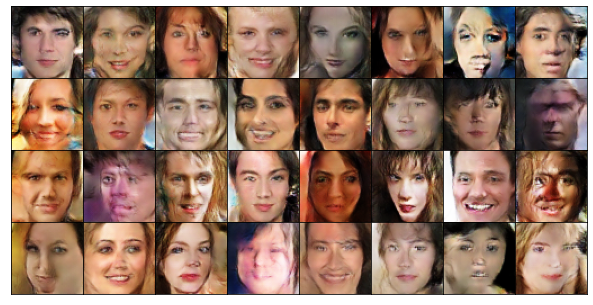

In [ ]:
same_seeds(0)

G = Generator(64).cuda()
G.load_state_dict(torch.load(os.path.join(path, 'p2_DCGAN_Generator.pkl')))
G.eval()

z_dim = 100 # latent dim - dimensionality of the latent space
z_sample = Variable(torch.randn(32, z_dim, 1, 1)).cuda()
fake_imgs_sample = (G(z_sample).data + 1) / 2.0

# show generated image
for i in range(32):
    plt.subplot(4, 8, i+1)
    fig = plt.gcf()
    fig.set_size_inches(8, 4) 
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.margins(0,0)
    plt.imshow(fake_imgs_sample[i].permute(1, 2, 0).data.cpu().numpy())

plt.savefig(os.path.join(path, 'p2_smaple_reconstructed.jpg')) 
plt.show()

torchvision.__version__ = 0.5.0
torch.cuda.is_available() = True


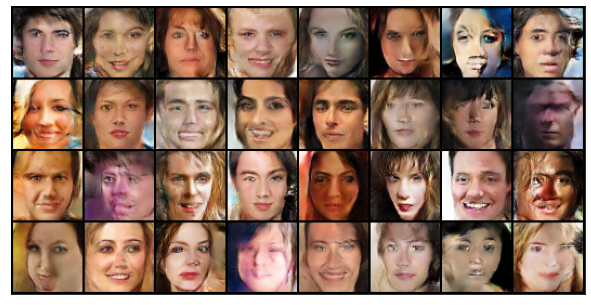

In [11]:
# use torch to save img
same_seeds(0)

G = Generator(64).cuda()
G.load_state_dict(torch.load(os.path.join(path, 'p2_DCGAN_Generator.pkl')))
G.eval()

z_dim = 100 # latent dim - dimensionality of the latent space
z_sample = Variable(torch.randn(32, z_dim, 1, 1)).cuda()
fake_imgs_sample = (G(z_sample).data + 1) / 2.0

torchvision.utils.save_image(fake_imgs_sample.cpu(), os.path.join(path, 'p2_smaple_reconstructed.jpg'), nrow=8)
grid_img = torchvision.utils.make_grid(fake_imgs_sample.cpu(), nrow=8)
fig = plt.gcf()
fig.set_size_inches(8, 4) 
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
plt.margins(0,0)
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

3. Discuss what you’ve observed and learned from implementing GAN. (5%)

4. Compare the difference between image generated by VAE and GAN, discuss what you’ve observed. (5%)   